In [5]:
import numpy as np
import yfinance as yf
import datetime

# === Basket Option Class ===
class EuropeanBasketCallOption:
    def __init__(self, spot_prices, volatilities, correlation_matrix, weights, strike_price,
                 time_to_maturity, risk_free_rate, num_simulations=100000):
        self.spot_prices = np.array(spot_prices)
        self.volatilities = np.array(volatilities)
        self.correlation_matrix = np.array(correlation_matrix)
        self.weights = np.array(weights)
        self.strike_price = strike_price
        self.T = time_to_maturity
        self.r = risk_free_rate
        self.num_simulations = num_simulations
        self.cholesky_matrix = np.linalg.cholesky(self.correlation_matrix)

    def simulate_payoff(self, return_basket_paths=False):
        n_assets = len(self.spot_prices)
        Z = np.random.normal(size=(self.num_simulations, n_assets))
        correlated_Z = Z @ self.cholesky_matrix.T

        drift = (self.r - 0.5 * self.volatilities ** 2) * self.T
        diffusion = self.volatilities * np.sqrt(self.T)

        # Broadcast
        drift = drift[None, :]
        diffusion = diffusion[None, :]

        terminal_prices = self.spot_prices * np.exp(drift + correlated_Z * diffusion)
        basket_values = terminal_prices @ self.weights
        payoffs = np.maximum(basket_values - self.strike_price, 0)
        discounted_payoffs = np.exp(-self.r * self.T) * payoffs

        option_price = np.mean(discounted_payoffs)
        std_error = np.std(discounted_payoffs) / np.sqrt(self.num_simulations)
        ci_low = option_price - 1.96 * std_error
        ci_high = option_price + 1.96 * std_error

        if return_basket_paths:
            return option_price, ci_low, ci_high, basket_values
        else:
            return option_price, ci_low, ci_high


# === Step 1: Define Stocks and Spot Prices ===
tickers = {
    "BHP": "BHP.AX",
    "CSL": "CSL.AX",
    "WDS": "WDS.AX",
    "MQG": "MQG.AX"
}

# Manually input spot prices as at 16 May 2025
spot_prices = [
    39.72,   # BHP
    241.82,  # CSL
    21.92,   # WDS
    207.35   # MQG
]

# === Step 2: Manually Input Implied Volatilities from Bloomberg ===
# Make sure you get IVMs for options expiring 17 July 2025 near the ATM strike
volatilities = [
    0.21064992905,  # BHP implied volatility (% as decimal)
    0.2108931923, # CSL implied volatility (example)
    0.2676087761,  # WDS implied volatility
    0.213292141  # MQG implied volatility
]

# === Step 3: Define Basket and Option Parameters ===
weights = [0.10, 0.35, 0.15, 0.40]
correlation_matrix = [
    [1.00, 0.629, 0.569, 0.632],
    [0.629, 1.00, 0.080, 0.498],
    [0.569, 0.080, 1.00, 0.770],
    [0.632, 0.498, 0.770, 1.00]
]
strike_price = 175.00

# Manually input current RBA cash rate as risk-free rate
risk_free_rate = 0.041  # Cash rate needs to change. 

# === Step 4: Calculate Time to Expiry ===
date_start = datetime.date(2025, 5, 16)
date_end = datetime.date(2025, 7, 17)
days_to_maturity = (date_end - date_start).days
time_to_maturity = days_to_maturity / 365

# === Step 5: Run Monte Carlo Simulation ===
basket_option = EuropeanBasketCallOption(
    spot_prices, volatilities, correlation_matrix, weights,
    strike_price, time_to_maturity, risk_free_rate
)

option_price, ci_low, ci_high = basket_option.simulate_payoff()

# === Step 6: Output Results ===
print("\n Spot Prices and Volatilities:")
for name, price, vol in zip(tickers.keys(), spot_prices, volatilities):
    print(f"{name}: Price = ${price:.2f}, Volatility = {vol:.2%}")

print(f"\n Estimated European Basket Call Option Price: ${option_price:.2f}")
print(f" 95% Confidence Interval: ${ci_low:.2f} to ${ci_high:.2f}")



 Spot Prices and Volatilities:
BHP: Price = $39.72, Volatility = 21.06%
CSL: Price = $241.82, Volatility = 21.09%
WDS: Price = $21.92, Volatility = 26.76%
MQG: Price = $207.35, Volatility = 21.33%

 Estimated European Basket Call Option Price: $5.79
 95% Confidence Interval: $5.74 to $5.84


# Create graph showing Monte Carlo simulations. 

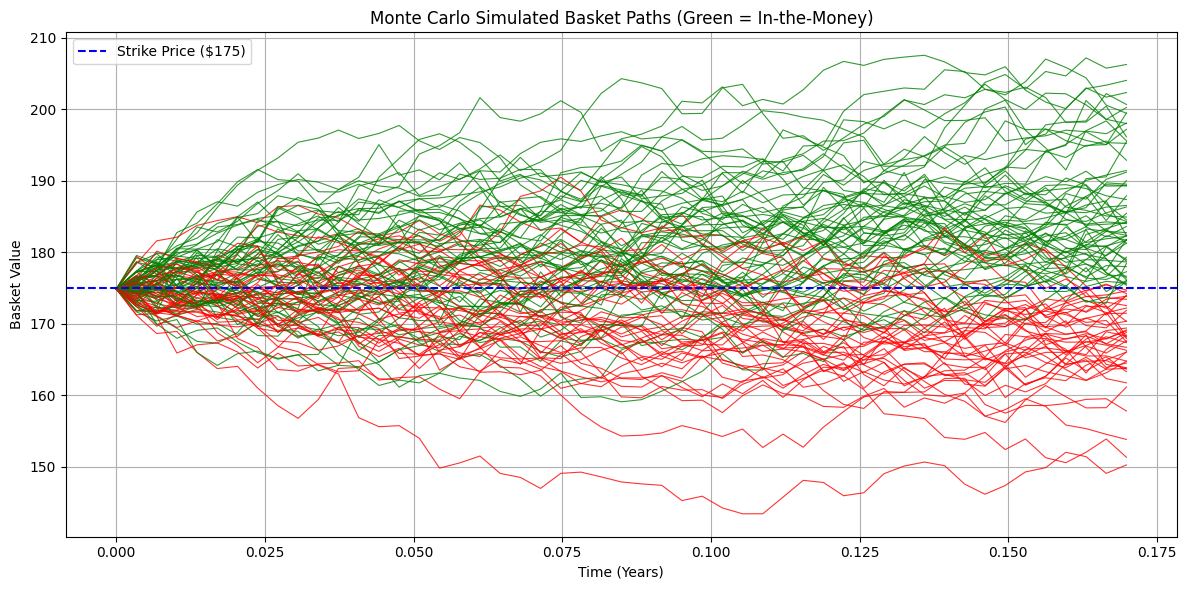

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# === Inputs ===
spot_prices = np.array([39.72, 241.82, 21.92, 207.35])
volatilities = np.array([0.21065, 0.21089, 0.26761, 0.21329])
correlation_matrix = np.array([
    [1.00, 0.629, 0.569, 0.632],
    [0.629, 1.00, 0.080, 0.498],
    [0.569, 0.080, 1.00, 0.770],
    [0.632, 0.498, 0.770, 1.00]
])
weights = np.array([0.10, 0.35, 0.15, 0.40])
r = 0.041
T = 62 / 365  # ~0.1699 years
n_steps = 50
n_paths = 100
strike_price = 175

# === Setup ===
dt = T / n_steps
n_assets = len(spot_prices)
cholesky = np.linalg.cholesky(correlation_matrix)

# === Storage for basket paths ===
basket_paths = np.zeros((n_paths, n_steps + 1))
basket_paths[:, 0] = np.dot(spot_prices, weights)

# === Simulate asset and basket paths ===
current_spots = np.tile(spot_prices, (n_paths, 1))  # shape: (n_paths, n_assets)

for t in range(1, n_steps + 1):
    Z = np.random.normal(size=(n_paths, n_assets))
    correlated_Z = Z @ cholesky.T

    drift = (r - 0.5 * volatilities**2) * dt
    diffusion = volatilities * np.sqrt(dt)

    # Update asset prices for each path
    current_spots *= np.exp(drift + diffusion * correlated_Z)

    # Compute basket value per path
    basket_values = np.dot(current_spots, weights)
    basket_paths[:, t] = basket_values

# === Plotting ===
plt.figure(figsize=(12, 6))
time_grid = np.linspace(0, T, n_steps + 1)

# Color-code paths
for i in range(n_paths):
    final_value = basket_paths[i, -1]
    color = 'green' if final_value > strike_price else 'red'
    plt.plot(time_grid, basket_paths[i], lw=0.8, alpha=0.8, color=color)

# Reference line for strike
plt.axhline(y=strike_price, color='blue', linestyle='--', label="Strike Price ($175)")

plt.title("Monte Carlo Simulated Basket Paths (Green = In-the-Money)")
plt.xlabel("Time (Years)")
plt.ylabel("Basket Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
